In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt

import skimage
import skimage.io
import skimage.transform

In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

CIFAR-10 Dataset: 171MB [00:10, 16.9MB/s]                              


In [3]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [4]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [5]:
def _preprocess_and_save(one_hot_encode, features, labels, filename):
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_testing.p')

In [6]:
preprocess_and_save_data(cifar10_dataset_folder_path, one_hot_encode)

In [7]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [8]:
import tensorflow as tf

from tensorflow.contrib.layers import conv2d
from tensorflow.contrib.layers import max_pool2d
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import fully_connected

In [9]:
def single_gpu_convnet(input):
    # 1st
    conv1 = conv2d(input, num_outputs=96,
                kernel_size=[11,11], stride=4, padding="VALID",
                activation_fn=tf.nn.relu)
    lrn1 = tf.nn.local_response_normalization(conv1, bias=2, alpha=0.0001,beta=0.75)
    pool1 = max_pool2d(lrn1, kernel_size=[3,3], stride=2)

    # 2nd
    conv2 = conv2d(pool1, num_outputs=256,
                kernel_size=[5,5], stride=1, padding="VALID",
                biases_initializer=tf.ones_initializer(),
                activation_fn=tf.nn.relu)
    lrn2 = tf.nn.local_response_normalization(conv2, bias=2, alpha=0.0001, beta=0.75)
    pool2 = max_pool2d(lrn2, kernel_size=[3,3], stride=2)

    #3rd
    conv3 = conv2d(pool2, num_outputs=384,
                kernel_size=[3,3], stride=1, padding="VALID",
                activation_fn=tf.nn.relu)

    #4th
    conv4 = conv2d(conv3, num_outputs=384,
                kernel_size=[3,3], stride=1, padding="VALID",
                biases_initializer=tf.ones_initializer(),
                activation_fn=tf.nn.relu)

    #5th
    conv5 = conv2d(conv4, num_outputs=256,
                kernel_size=[3,3], stride=1, padding="VALID",
                biases_initializer=tf.ones_initializer(),
                activation_fn=tf.nn.relu)
    pool5 = max_pool2d(conv5, kernel_size=[3,3], stride=2)

    #6th
    flat = flatten(pool5)
    fcl1 = fully_connected(flat, num_outputs=4096,
                            biases_initializer=tf.ones_initializer(), activation_fn=tf.nn.relu)
    dr1 = tf.nn.dropout(fcl1, 0.5)

    #7th
    fcl2 = fully_connected(dr1, num_outputs=4096,
                            biases_initializer=tf.ones_initializer(), activation_fn=tf.nn.relu)
    dr2 = tf.nn.dropout(fcl2, 0.5)

    #output
    out = fully_connected(dr2, num_outputs=10, activation_fn=None)
    return out

In [10]:
learning_rate = 0.00005

input = tf.placeholder(tf.float32, [None, 224, 224, 3], name='input_x')
label = tf.placeholder(tf.int32, [None, 10], name='output_y')

logits = single_gpu_convnet(input)
model = tf.identity(logits, name='logits')

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=label))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [11]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [12]:
def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    
    tmpFeatures = []
    
    for feature in features:
        tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
        tmpFeatures.append(tmpFeature)

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(tmpFeatures, labels, batch_size)

In [13]:
tmpValidFeatures = []
for feature in valid_features[:3000]:
    tmpValidFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
    tmpValidFeatures.append(tmpValidFeature)
    
tmpValidFeatures = np.array(tmpValidFeatures)

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [20]:
epochs = 20
batch_size = 64

save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:    
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    print('global_variables_initializer ... done ...')
    
    # Training cycle
    print('starting training ... ')
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5

        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                sess.run(optimizer, {input: batch_features, label: batch_labels})
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            
            # calculate the mean accuracy over all validation dataset
            valid_acc = 0
            for batch_valid_features, batch_valid_labels in batch_features_labels(tmpValidFeatures, valid_labels, batch_size):
                valid_acc += sess.run(accuracy, {input:batch_valid_features, label:batch_valid_labels})
            
            tmp_num = tmpValidFeatures.shape[0]/batch_size
            print('Validation Accuracy: {:.6f}'.format(valid_acc/tmp_num))
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
global_variables_initializer ... done ...
starting training ... 


/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch  1, CIFAR-10 Batch 1:  Validation Accuracy: 0.089048
Epoch  1, CIFAR-10 Batch 2:  Validation Accuracy: 0.121810
Epoch  1, CIFAR-10 Batch 3:  Validation Accuracy: 0.169429
Epoch  1, CIFAR-10 Batch 4:  Validation Accuracy: 0.175857
Epoch  1, CIFAR-10 Batch 5:  Validation Accuracy: 0.188476
Epoch  2, CIFAR-10 Batch 1:  Validation Accuracy: 0.194095
Epoch  2, CIFAR-10 Batch 2:  Validation Accuracy: 0.195095
Epoch  2, CIFAR-10 Batch 3:  Validation Accuracy: 0.226952
Epoch  2, CIFAR-10 Batch 4:  Validation Accuracy: 0.245667
Epoch  2, CIFAR-10 Batch 5:  Validation Accuracy: 0.248381
Epoch  3, CIFAR-10 Batch 1:  Validation Accuracy: 0.269762
Epoch  3, CIFAR-10 Batch 2:  Validation Accuracy: 0.267524
Epoch  3, CIFAR-10 Batch 3:  Validation Accuracy: 0.289571
Epoch  3, CIFAR-10 Batch 4:  Validation Accuracy: 0.309095
Epoch  3, CIFAR-10 Batch 5:  Validation Accuracy: 0.310429
Epoch  4, CIFAR-10 Batch 1:  Validation Accuracy: 0.330333
Epoch  4, CIFAR-10 Batch 2:  Validation Accuracy: 0.3371

In [21]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [22]:
from sklearn.preprocessing import LabelBinarizer

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))

    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    
    for image_i, (feature, label_id, prediction) in enumerate(zip(features, label_ids, predictions)):
        correct_name = label_names[label_id]
        pred_name = label_names[np.argmax(prediction)]
        
        is_match = 'False'        
        
        if np.argmax(prediction) == label_id:
            is_match = 'True'
            
        predictions_array = []
        pred_names = []
        
        for index, pred_value in enumerate(prediction):
            tmp_pred_name = label_names[index]
            predictions_array.append({tmp_pred_name : pred_value})
            pred_names.append(tmp_pred_name)
        
        print('[{}] ground truth: {}, predicted result: {} | {}'.format(image_i, correct_name, pred_name, is_match))
        print('\t- {}\n'.format(predictions_array))
        
#         print('image_i: ', image_i)
#         print('axs: ', axs, ', axs len: ', len(axs))
        axs[image_i][0].imshow(feature)
        axs[image_i][0].set_title(pred_name)
        axs[image_i][0].set_axis_off()
        
        axs[image_i][1].barh(ind + margin, prediction, width)
        axs[image_i][1].set_yticks(ind + margin)
        axs[image_i][1].set_yticklabels(pred_names)
        
    plt.tight_layout()

In [23]:
test_features, test_labels = pickle.load(open('preprocess_testing.p', mode='rb'))
tmpFeatures = []

for feature in test_features:
    tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
    tmpFeatures.append(tmpFeature)

tmpFeatures = np.asarray(tmpFeatures)

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6548566878980892



/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


[0] ground truth: airplane, predicted result: airplane | True
	- [{'airplane': 0.53563225}, {'automobile': 4.0836512e-05}, {'bird': 0.26658392}, {'cat': 0.0073251915}, {'deer': 0.1725201}, {'dog': 0.001247288}, {'frog': 0.00016687748}, {'horse': 0.014020207}, {'ship': 0.0015065238}, {'truck': 0.00095678325}]

[1] ground truth: cat, predicted result: horse | False
	- [{'airplane': 0.0046135657}, {'automobile': 3.0598007e-05}, {'bird': 0.020515645}, {'cat': 0.06810263}, {'deer': 0.00847858}, {'dog': 0.10941909}, {'frog': 0.00012377936}, {'horse': 0.7884925}, {'ship': 6.08159e-05}, {'truck': 0.0001627358}]

[2] ground truth: horse, predicted result: horse | True
	- [{'airplane': 0.0023158828}, {'automobile': 0.00034880004}, {'bird': 0.03430273}, {'cat': 0.026681883}, {'deer': 0.009133822}, {'dog': 0.35065132}, {'frog': 0.005351364}, {'horse': 0.55782735}, {'ship': 0.0020228182}, {'truck': 0.0113640195}]

[3] ground truth: horse, predicted result: horse | True
	- [{'airplane': 0.0070463857

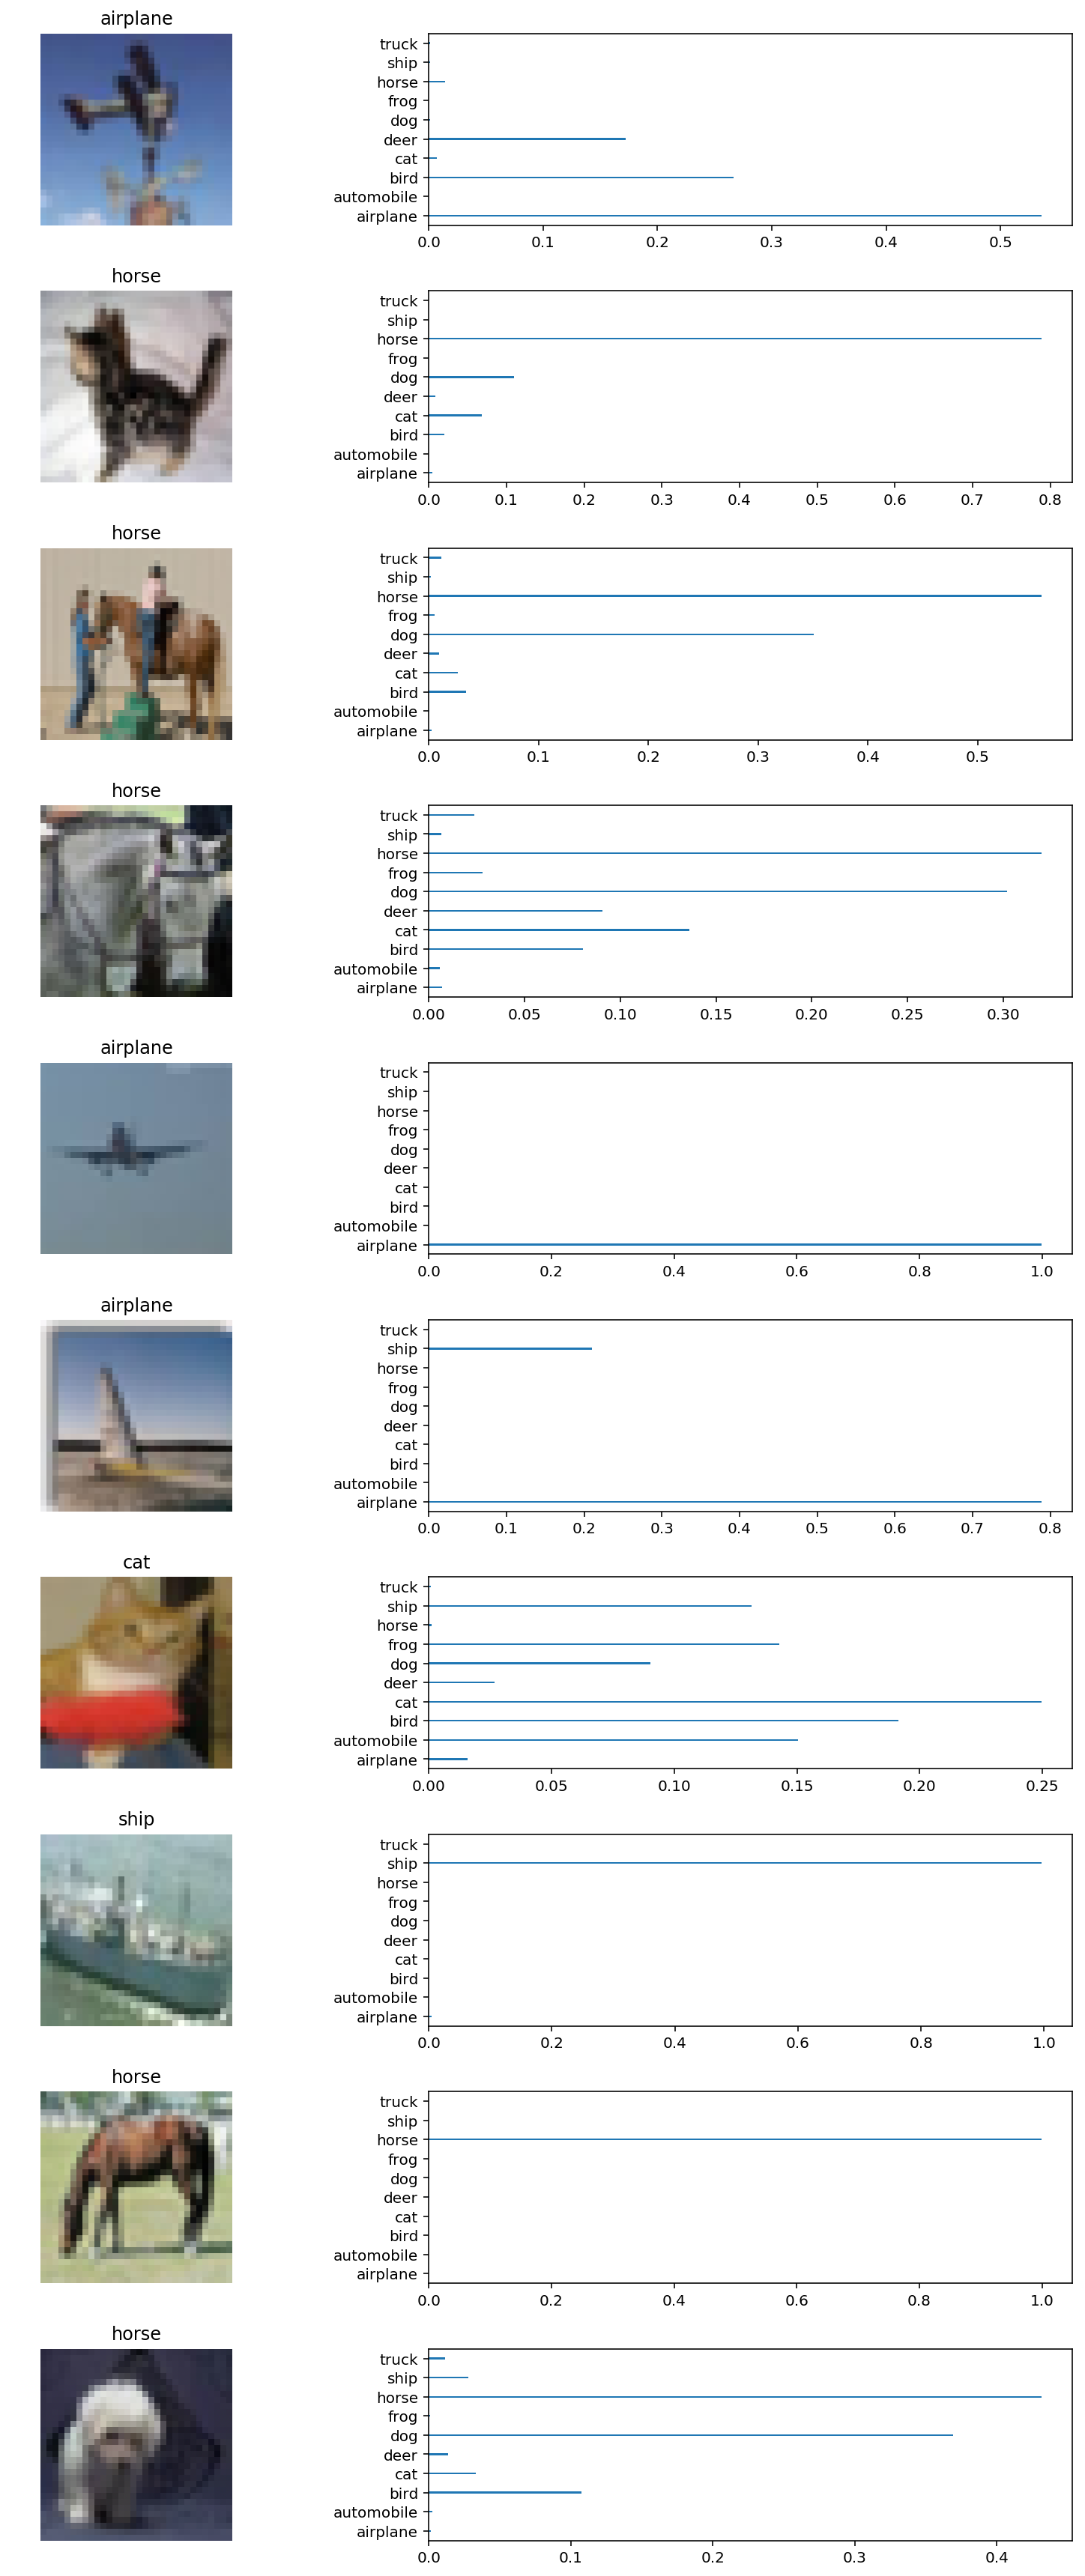

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model(tmpFeatures):
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        for train_feature_batch, train_label_batch in batch_features_labels(tmpFeatures, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        tmpTestFeatures = []
    
        for feature in random_test_features:
            tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
            tmpTestFeatures.append(tmpFeature)
           
        random_test_predictions = sess.run(
            tf.nn.softmax(loaded_logits),
            feed_dict={loaded_x: tmpTestFeatures, loaded_y: random_test_labels})
        
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model(tmpFeatures)